# check support for $p(\theta_g\,|\,M_g, M_r, M_i, M_z, \sigma_g, \sigma_r, \sigma_i, \sigma_z)$
and derive cuts appropriate for selecting NSA galaxies

In [1]:
import os
import h5py 
import numpy as np

In [2]:
import astropy.table as aTable

In [3]:
import corner as DFM
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## load NASA-Sloan Atlas

In [4]:
dat_dir = '/tigress/chhahn/cgpop/'

nsa = aTable.Table.read(os.path.join(dat_dir, 'nsa_v0_1_2.fits'))
absmag_nsa = np.array(nsa['ABSMAG'].data)[:,3:] # g, r, i, z
ivar_absmag_nsa = np.array(nsa['AMIVAR'].data)[:,3:]

In [5]:
cuts = (np.all((ivar_absmag_nsa[:,:-1]**-0.5 > 0.02) & (ivar_absmag_nsa[:,:-1]**-0.5 < 0.022), axis=1) & 
        (ivar_absmag_nsa[:,-1]**-0.5 > 0.03) & (ivar_absmag_nsa[:,-1]**-0.5 < 0.04))
np.sum(cuts)

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  


98792

## load CAMELS-TNG

In [8]:
f = h5py.File(os.path.join(dat_dir, 'tng.snap33.subfind.galaxies.LHC.hdf5'), 'r')
props = f['props'][...].T
f.close()

In [9]:
props[:,6] = np.log10(props[:,6])
props[:,7] = np.log10(props[:,7])
props[:,13] = np.log10(props[:,13])
props[:,17] = np.log10(props[:,17])

props = props[np.isfinite(props[:,6])]

# Om, s8, Asn1, Aagn1, Asn2, Aagn2, Mg, Mstar, Mbh, Mtot, Vmax, Vdisp, Zg, Zs, SFR, J, Vel, Rstar, Rtot, Rvmax,
# absmag U, B, V, K, g, r, i, z
lbls = [r'$\Omega_m$', r'$\sigma_8$', r'$A_{\rm SN1}$', r'$A_{\rm AGN1}$', r'$A_{\rm SN2}$', r'$A_{\rm AGN2}$', 
        r'$\log M_g$', r'$\log M_*$', r'$M_{\rm BH}$', r'$M_{\rm tot}$', r'$V_{\rm max}$', r'$V_{\rm disp}$', 
        r'$Z_g$', r'$\log Z_*$', 'SFR', 'J', 'V', r'$\log R_*$', r'$R_{\rm tot}$', r'$R_{\rm vmax}$', 
        r'$U$ absmag', r'$B$ absmag', r'$V$ absmag', r'$K$ absmag', r'$g$ absmag', r'$r$ absmag', r'$i$ absmag', 
        r'$z$ absmag']

icosmo = [0, 1, 2, 3, 4, 5] # cosmological/hydro parameters
igals = [6, 7, 10, 13, 17] # intrinsic properties of galaixes (Mg, M*, Vmax, Z*, R*)
iobs = [-4, -3, -2, -1]

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [10]:
sigma_absmags_camels = np.random.uniform(0.019, 0.023, size=(props.shape[0], len(iobs)))
sigma_absmags_camels[:,-1] = np.random.uniform(0.029, 0.041, size=(props.shape[0]))
absmags_camels = props[:,np.array(iobs)] + sigma_absmags_camels * np.random.normal(size=(props.shape[0], len(iobs)))

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


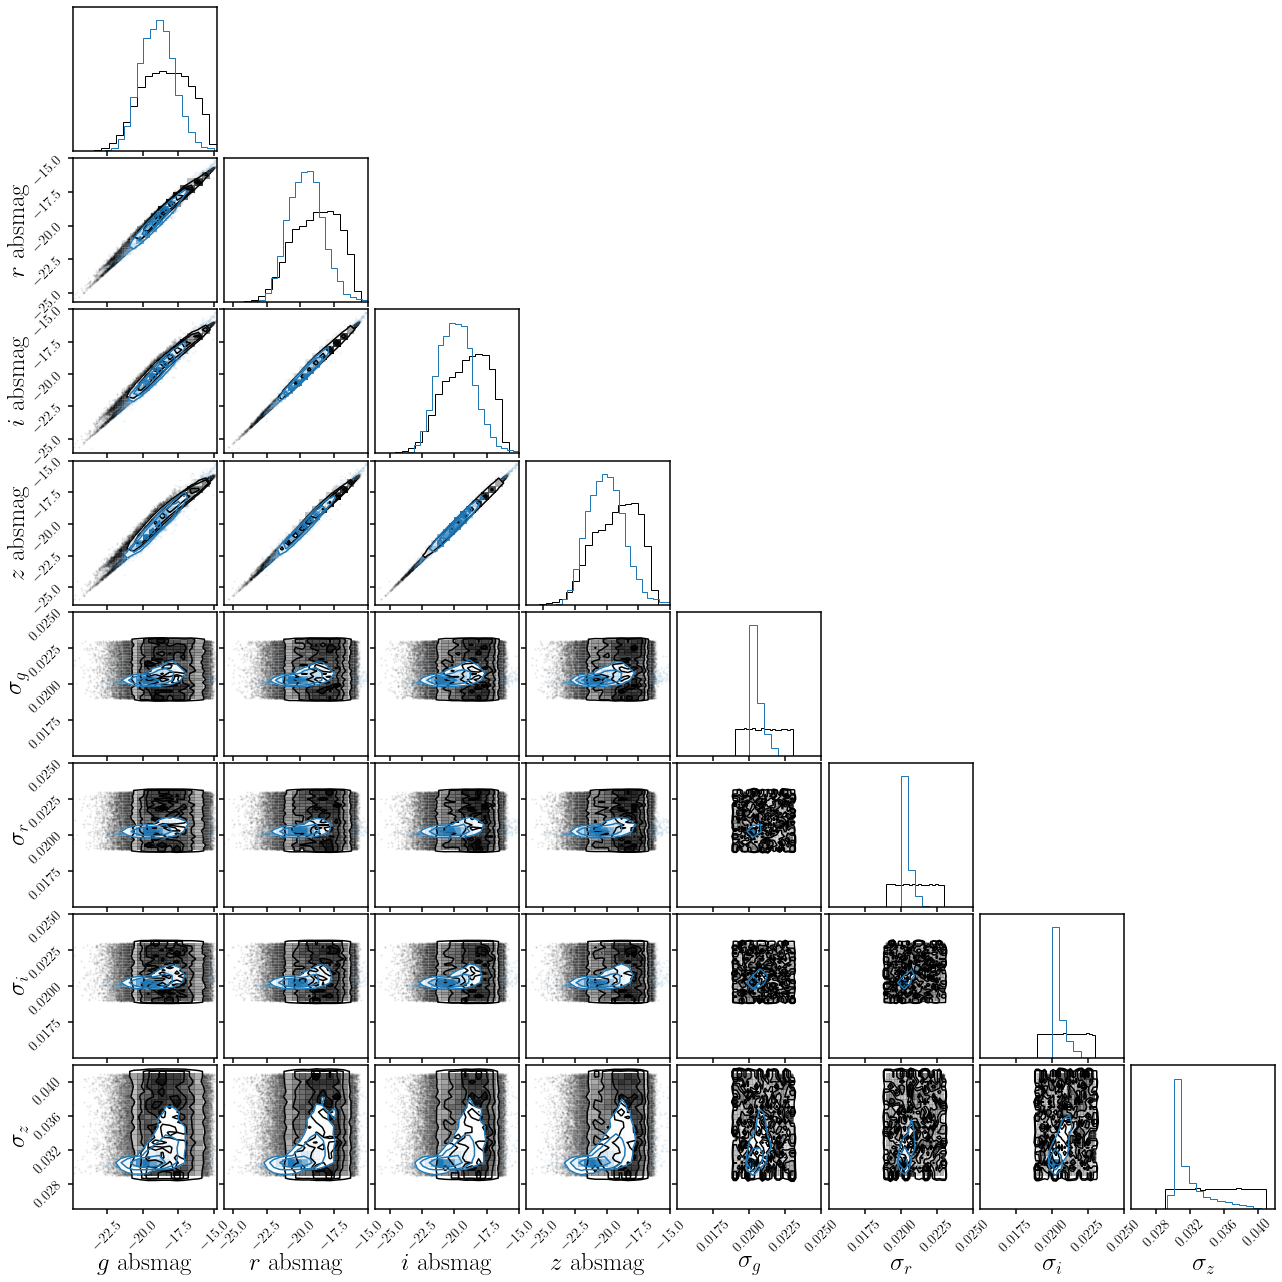

In [12]:
fig = DFM.corner(np.concatenate([absmags_camels, sigma_absmags_camels], axis=1)[::10], color='k', 
                hist_kwargs={'density': True})
_ = DFM.corner(np.concatenate([absmag_nsa, ivar_absmag_nsa**-0.5], axis=1)[cuts][::10], color='C0', 
               hist_kwargs={'density': True},
               range=[(-24, -15) for i in range(4)] + [(0.015, 0.025) for i in range(3)] + [(0.025, 0.042)],
               labels=[lbls[i] for i in iobs] + [r'$\sigma_g$', r'$\sigma_r$', r'$\sigma_i$', r'$\sigma_z$'],
               label_kwargs={'fontsize': 25}, 
               fig=fig)

In [13]:
cuts_absmag = np.ones(absmag_nsa.shape[0]).astype(bool)
for i in range(4): 
    cuts_absmag = cuts_absmag & (absmag_nsa[:,i] < -16) & (absmag_nsa[:,i] > -20.)

## check colors $g-r, r-i, i-z$, ...

In [14]:
colors_camels = np.array([absmags_camels[:,0] - absmags_camels[:,1], 
                           absmags_camels[:,0] - absmags_camels[:,2],
                           absmags_camels[:,0] - absmags_camels[:,3],
                           absmags_camels[:,1] - absmags_camels[:,2],
                           absmags_camels[:,1] - absmags_camels[:,3],
                           absmags_camels[:,2] - absmags_camels[:,3]]).T
colors_nsa = np.array([absmag_nsa[:,0] - absmag_nsa[:,1], 
                         absmag_nsa[:,0] - absmag_nsa[:,2], 
                         absmag_nsa[:,0] - absmag_nsa[:,3], 
                         absmag_nsa[:,1] - absmag_nsa[:,2], 
                         absmag_nsa[:,1] - absmag_nsa[:,3],
                         absmag_nsa[:,2] - absmag_nsa[:,3]]).T

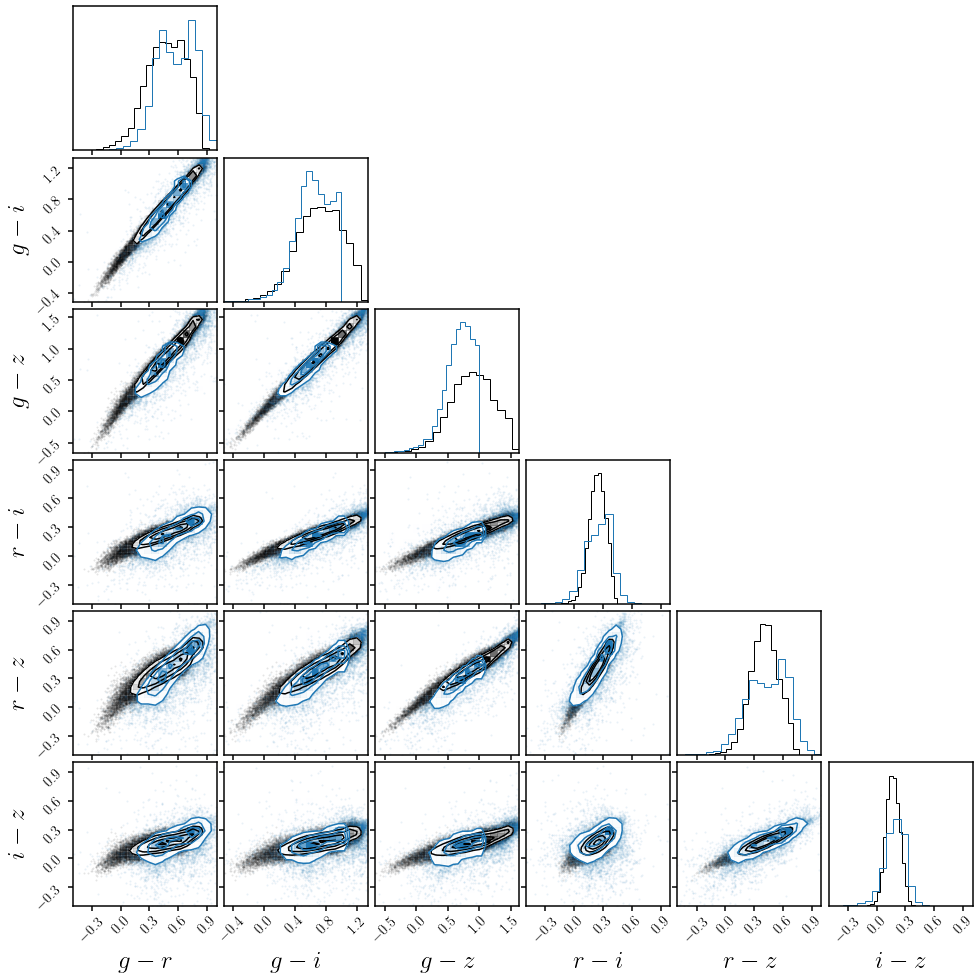

In [15]:
fig = DFM.corner(colors_camels[::10], color='k', 
                hist_kwargs={'density': True})
_ = DFM.corner(colors_nsa[::10], color='C0', 
               hist_kwargs={'density': True},
               range=[(-0.5, 1), (-0.5, 1), (-0.5, 1), (-0.5, 1), (-0.5, 1), (-0.5, 1)],
               labels=['$g-r$', '$g-i$', '$g-z$', '$r-i$', '$r-z$', '$i-z$'],
               label_kwargs={'fontsize': 25}, 
               fig=fig)

In [16]:
color_lims = np.quantile(colors_camels, [0.16, 0.84], axis=0)

In [22]:
print(color_lims)

[[0.26391692 0.42210869 0.53792424 0.15047391 0.26251017 0.09671507]
 [0.68782795 1.00967182 1.23166971 0.329177   0.55766533 0.2415818 ]]


In [17]:
cuts_color = np.ones(len(colors_nsa)).astype(bool)
for icolor in range(color_lims.shape[1]): 
    cuts_color = (cuts_color & 
                  (colors_nsa[:,icolor] > color_lims[0,icolor]) & 
                  (colors_nsa[:,icolor] < color_lims[1,icolor]))

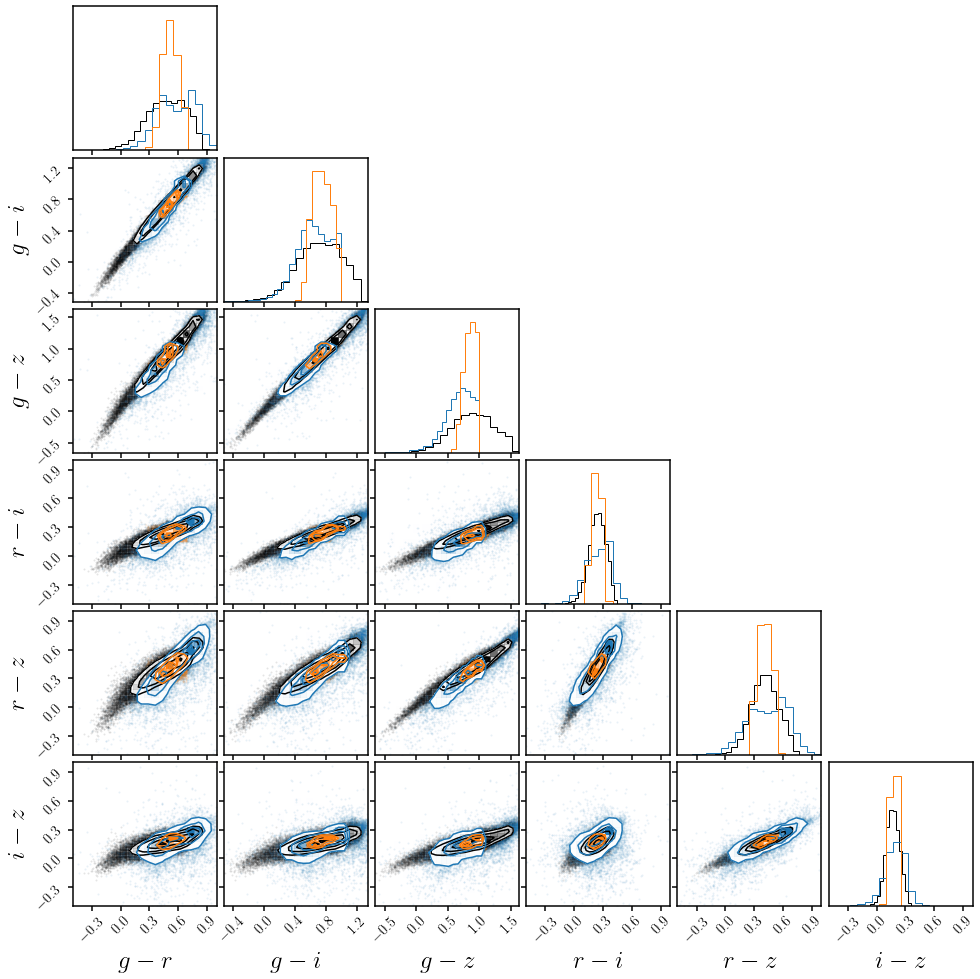

In [18]:
fig = DFM.corner(colors_camels[::10], color='k', 
                hist_kwargs={'density': True})
_ = DFM.corner(colors_nsa[::10], color='C0', 
               hist_kwargs={'density': True},
               range=[(-0.5, 1), (-0.5, 1), (-0.5, 1), (-0.5, 1), (-0.5, 1), (-0.5, 1)],
               labels=['$g-r$', '$g-i$', '$g-z$', '$r-i$', '$r-z$', '$i-z$'],
               label_kwargs={'fontsize': 25}, 
               fig=fig)
_ = DFM.corner(colors_nsa[cuts_color], color='C1', 
               hist_kwargs={'density': True},
               range=[(-0.5, 1), (-0.5, 1), (-0.5, 1), (-0.5, 1), (-0.5, 1), (-0.5, 1)],
               labels=['$g-r$', '$g-i$', '$g-z$', '$r-i$', '$r-z$', '$i-z$'],
               label_kwargs={'fontsize': 25}, 
               fig=fig)

In [19]:
np.sum(cuts & cuts_absmag & cuts_color)

14469

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


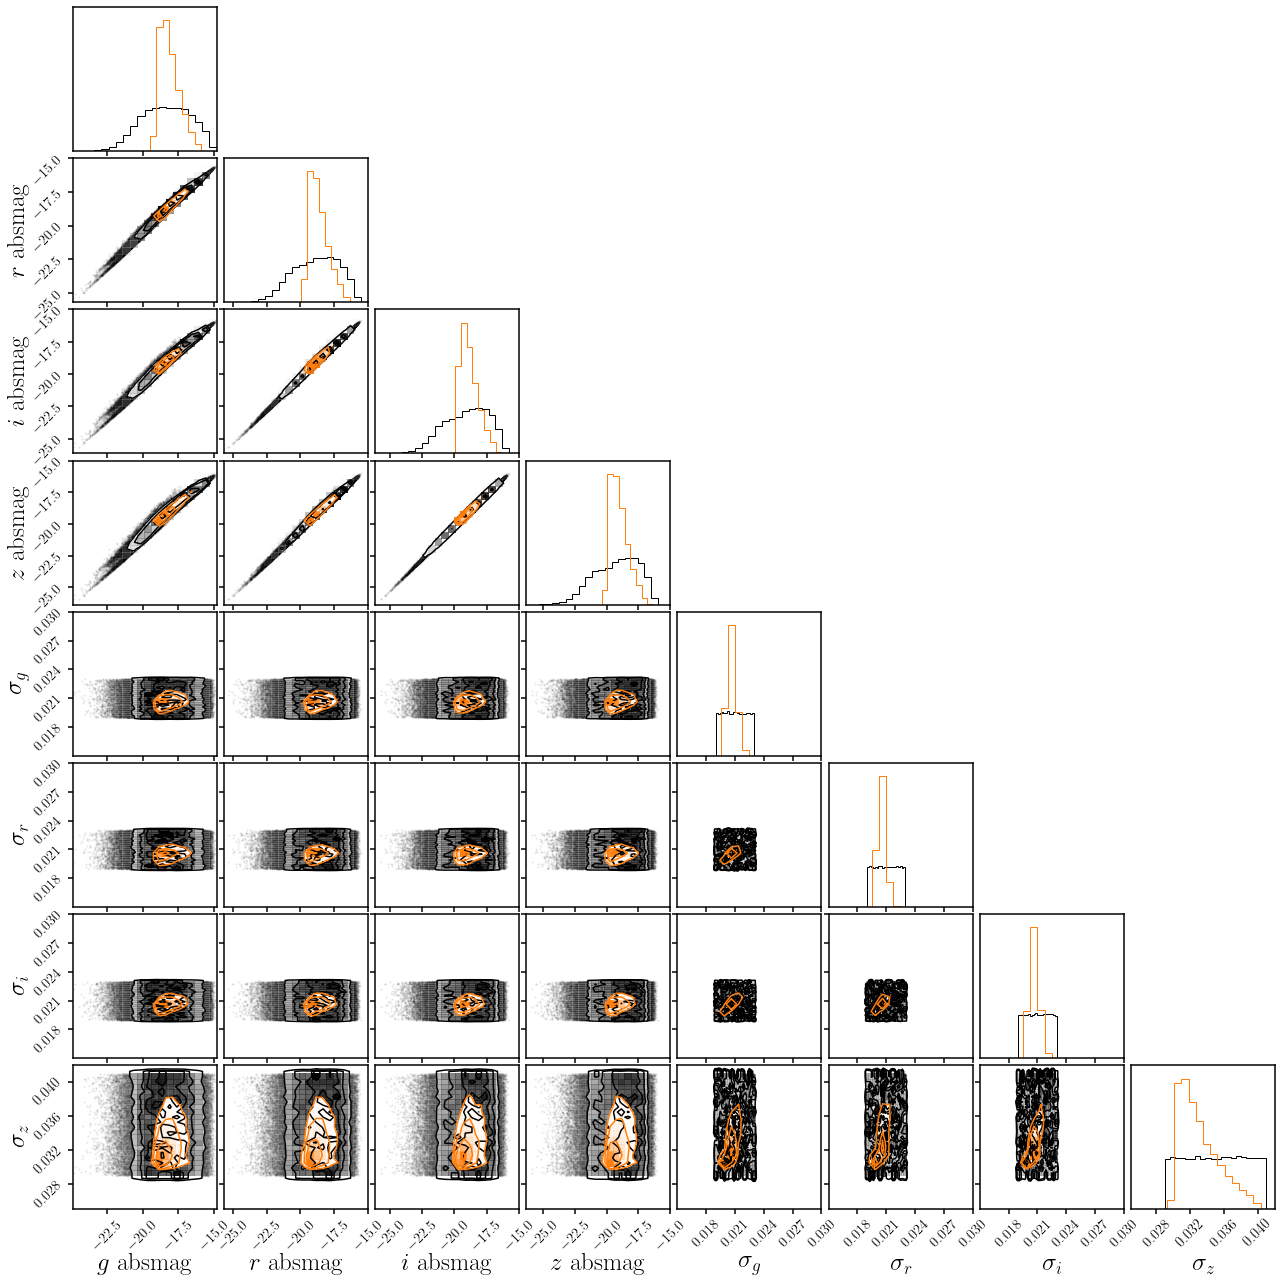

In [21]:
fig = DFM.corner(np.concatenate([absmags_camels, sigma_absmags_camels], axis=1)[::10], color='k', 
                hist_kwargs={'density': True})
_ = DFM.corner(np.concatenate([absmag_nsa, ivar_absmag_nsa**-0.5], axis=1)[cuts & cuts_absmag & cuts_color], color='C1', 
               hist_kwargs={'density': True},
               range=[(-24, -15) for i in range(4)] + [(0.015, 0.03) for i in range(3)] + [(0.025, 0.042)],
               labels=[lbls[i] for i in iobs] + [r'$\sigma_g$', r'$\sigma_r$', r'$\sigma_i$', r'$\sigma_z$'],
               label_kwargs={'fontsize': 25}, 
               fig=fig)